<a href="https://colab.research.google.com/github/wjy4399/LUKE/blob/main/LUKE/Supervised_relation_extraction_with_LukeForEntityPairClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune [`LukeForEntityPairClassification`](https://huggingface.co/transformers/model_doc/luke.html#lukeforentitypairclassification) on a supervised **relation extraction** dataset.

The goal for the model is to predict, given a sentence and the character spans of two entities within the sentence, the relationship between the entities.

The author of LUKE has fine-tuned this model on the [TACRED](https://nlp.stanford.edu/projects/tacred/) dataset, an important supervised relation extraction dataset by Stanford University, and obtains state-of-the-art results with it.

* Paper: https://arxiv.org/abs/2010.01057
* Original repository: https://github.com/studio-ousia/luke

## Read in data

Let's download the data from the web, hosted on Dropbox.

In [1]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/izi2x4sjohpzoot/relation_extraction_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Each row in the dataframe consists of a news article, and a sentence in which a certain relationship was found (just as "invested_in", or "founded_by"). There were some patterns used to gather the data, so it might contain some noise.

In [2]:
import pandas as pd

df = pd.read_pickle("relation_extraction_dataset.pkl")
df.reset_index(drop=True, inplace=True)
df.head()

,end_idx,entities,entity_spans,match,original_article,sentence,start_idx,string_id
0,1024,"[Lilium, Baillie Gifford]","[[3, 9], [151, 166]]",raising $35,Happy Friday!\n\nWe sincerely hope you and you...,"3) Lilium, a German startup that’s making an a...",1013,invested_in
1,1762,"[Facebook ’s, Giphy]","[[92, 102], [148, 153]]",acquisition,Happy Friday!\n\nWe sincerely hope you and you...,"Meanwhile, the UK’s watchdog on Friday announc...",1751,acquired_by
2,2784,"[Global-e, Vitruvian Partners]","[[27, 35], [94, 112]]",raised $60,Happy Friday!\n\nWe sincerely hope you and you...,Israeli e-commerce startup Global-e has raised...,2774,invested_in
3,680,"[Joris Van Der Gucht, Silverfin]","[[0, 19], [35, 44]]",founder,Hg is a leading investor in tax and accounting...,"Joris Van Der Gucht, co-founder at Silverfin c...",673,founded_by
4,2070,"[Tim Vandecasteele, Silverfin]","[[0, 17], [71, 80]]",founder,Hg is a leading investor in tax and accounting...,"Tim Vandecasteele, co-founder added: ""We want ...",2063,founded_by


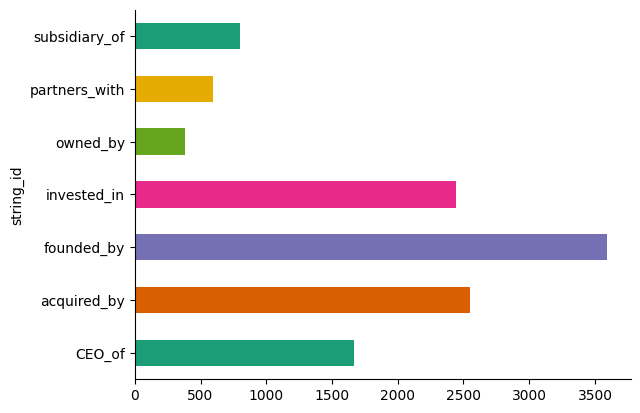

In [3]:
# @title string_id

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('string_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Let's create 2 dictionaries, one that maps each label to a unique integer, and one that does it the other way around.

In [4]:
id2label = dict()
for idx, label in enumerate(df.string_id.value_counts().index):
  id2label[idx] = label

As we can see, there are 7 labels (7 unique relationships):

In [5]:
id2label

{0: 'founded_by',
 1: 'acquired_by',
 2: 'invested_in',
 3: 'CEO_of',
 4: 'subsidiary_of',
 5: 'partners_with',
 6: 'owned_by'}

In [24]:
label2id = {v:k for k,v in id2label.items()}
label2id

{'founded_by': 0,
 'acquired_by': 1,
 'invested_in': 2,
 'CEO_of': 3,
 'subsidiary_of': 4,
 'partners_with': 5,
 'owned_by': 6}

In [ ]:
df.shape

(12031, 8)

## Define the PyTorch dataset and dataloaders

Next, we define regular PyTorch datasets and corresponding dataloaders. In PyTorch, you need to define a `Dataset` class that inherits from `torch.utils.data.Dataset`, and you need to implement 3 methods: the `init` method (for initializing the dataset with data), the `len` method (which returns the number of elements in the dataset) and the `getitem()` method, which returns a single item from the dataset.

In our case, each item of the dataset consists of a sentence, the spans of 2 entities in the sentence, and a label of the relationship. We use `LukeTokenizer` (available in the Transformers library) to turn these into the inputs expected by the model, which are `input_ids`, `entity_ids`, `attention_mask`, `entity_attention_mask` and `entity_position_ids`.

For more information regarding these inputs, refer to the [docs](https://huggingface.co/transformers/model_doc/luke.html#lukeforentitypairclassification) of `LukeForEntityPairClassification`.


In [8]:
!pip install mindnlp mindspore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.2/971.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: pytest
    Found existing installation: pytest 8.3.4
    Uninstalling pytest-8.3.4:
      Success

In [38]:
from mindnlp.transformers import LukeTokenizer
from mindspore.dataset import GeneratorDataset
import mindspore as ms
import numpy as np
import pandas as pd

df = pd.read_pickle("relation_extraction_dataset.pkl")
df.reset_index(drop=True, inplace=True)
df.head()
label2id={'founded_by': 0,
 'acquired_by': 1,
 'invested_in': 2,
 'CEO_of': 3,
 'subsidiary_of': 4,
 'partners_with': 5,
 'owned_by': 6}
# 初始化LukeTokenizer，指定预训练模型和任务类型
tokenizer = LukeTokenizer.from_pretrained("studio-ousia/luke-base", task="entity_pair_classification")

class RelationExtractionDataset:
    """关系抽取数据集。"""

    def __init__(self, data):
        self.data = data  # 数据保存为类属性

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        sentence = item.sentence
        entity_spans = [tuple(x) for x in item.entity_spans]

        # 使用 tokenizer 编码，返回 numpy 数组
        encoding = tokenizer(
            sentence,
            entity_spans=entity_spans,
            padding="max_length",
            truncation=True,
            return_tensors="np"
        )

        # 从 encoding 中获取 numpy 数组
        input_ids = encoding["input_ids"]
        attention_mask = encoding["attention_mask"]
        # 如果有实体相关的键，确保存在，否则给默认值
        entity_ids = encoding.get("entity_ids", np.zeros_like(input_ids))
        entity_position_ids = encoding.get("entity_position_ids", np.zeros_like(input_ids))
        entity_attention_mask = encoding.get("entity_attention_mask", np.zeros_like(input_ids))
        label = np.array([label2id[item.string_id]], dtype=np.int32)

        # 将 numpy 数组转换为 MindSpore 张量
        input_ids = ms.Tensor(input_ids)
        attention_mask = ms.Tensor(attention_mask)
        entity_ids = ms.Tensor(entity_ids)
        entity_position_ids = ms.Tensor(entity_position_ids)
        entity_attention_mask = ms.Tensor(entity_attention_mask)
        label = ms.Tensor(label)

        return input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask, label

# 构造生成器
def dataset_generator(dataframe, dataset_class):
    dataset = dataset_class(dataframe)
    for i in range(len(dataset)):
        yield dataset[i]

# 使用sklearn分割数据集
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=False)


train_dataset = GeneratorDataset(
    source=dataset_generator(train_df, RelationExtractionDataset),
    column_names=["input_ids", "entity_ids", "entity_position_ids", "attention_mask", "entity_attention_mask", "label"],
    shuffle=True
)
valid_dataset = GeneratorDataset(
    source=dataset_generator(val_df, RelationExtractionDataset),
    column_names=["input_ids", "entity_ids", "entity_position_ids", "attention_mask", "entity_attention_mask", "label"]
)
test_dataset = GeneratorDataset(
    source=dataset_generator(test_df, RelationExtractionDataset),
    column_names=["input_ids", "entity_ids", "entity_position_ids", "attention_mask", "entity_attention_mask", "label"]
)

# 设置批量大小
train_dataloader = train_dataset.batch(4)
valid_dataloader = valid_dataset.batch(2)
test_dataloader = test_dataset.batch(2)


/usr/local/lib/python3.10/dist-packages/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(


In [39]:
for batch in train_dataset.create_dict_iterator():
    print("Batch keys:", batch.keys())
    for key in ["input_ids", "entity_ids", "entity_position_ids", "attention_mask", "entity_attention_mask", "label"]:
        print(f"{key}: {batch[key].shape}")
    break


Batch keys: dict_keys(['input_ids', 'entity_ids', 'entity_position_ids', 'attention_mask', 'entity_attention_mask', 'label'])
input_ids: (1, 512)
entity_ids: (1, 2)
entity_position_ids: (1, 2, 30)
attention_mask: (1, 512)
entity_attention_mask: (1, 2)
label: (1,)


In [40]:
for batch in train_dataset.create_dict_iterator():
    # 如果 batch["label"] 是标量
    label_id = batch["label"].asnumpy().item()  # 提取标量值
    label_name = id2label[label_id]
    print(f"Label: {label_name}")
    break


Label: founded_by


## Define a PyTorch LightningModule

Let's define the model as a PyTorch LightningModule. A `LightningModule` is actually an `nn.Module`, but with some extra functionality.

For more information regarding how to define this, see the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.56317931.1395871250.1622709933-1738348008.1615553774) of PyTorch Lightning.

In [37]:
import mindspore as ms
import mindspore.nn as nn
from mindnlp.transformers import LukeForEntityPairClassification
from mindnlp.core.optim import AdamW
from mindnlp.core import no_grad
from mindspore import ops
import numpy as np


class LUKE(nn.Cell):
    def __init__(self, num_labels):
        super(LUKE, self).__init__()
        # 使用 self.model 来引用预训练的LUKE模型
        self.model = LukeForEntityPairClassification.from_pretrained(
            "studio-ousia/luke-base",

            num_labels=num_labels
        )
        print("Number of parameters inside __init__:", len(self.model.trainable_params()))
        self.loss_fn = nn.CrossEntropyLoss()

    def construct(self, input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            entity_ids=entity_ids,
            entity_attention_mask=entity_attention_mask,
            entity_position_ids=entity_position_ids
        )
        logits = outputs.logits
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits
        else:
            return logits

# 实例化模型
num_labels = len(label2id)
model = LUKE(num_labels)
print("Number of parameters outside:", len(model.trainable_params()))

# 定义优化器
optimizer = AdamW(model.trainable_params(), lr=5e-5)

# 可选：实现 Early Stopping
class EarlyStopping:
    def __init__(self, patience=2, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=2)

def evaluate(model, dataloader):
    model.set_train(False)
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader.create_dict_iterator():
        input_ids = batch["input_ids"]
        entity_ids = batch["entity_ids"]
        entity_position_ids = batch["entity_position_ids"]
        attention_mask = batch["attention_mask"]
        entity_attention_mask = batch["entity_attention_mask"]
        labels = batch["label"]

        loss, logits = model(input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask, labels)
        total_loss += loss.asnumpy()
        predictions = logits.argmax(axis=-1)
        correct = (predictions == labels).asnumpy().sum()
        total_correct += correct
        total_samples += labels.shape[0]

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def train(model, optimizer, train_dataloader, valid_dataloader, epochs=3):
    # 使用 ops.value_and_grad 来计算梯度
    def forward_fn(input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask, labels):
        loss, logits = model(input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask, labels)
        return loss, logits

    grad_fn = ops.value_and_grad(forward_fn, grad_position=None, weights=model.trainable_params())

    for epoch in range(epochs):
        model.set_train(True)
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch in train_dataloader.create_dict_iterator():
            input_ids = batch["input_ids"]
            entity_ids = batch["entity_ids"]
            entity_position_ids = batch["entity_position_ids"]
            attention_mask = batch["attention_mask"]
            entity_attention_mask = batch["entity_attention_mask"]
            labels = batch["label"]

            # 计算loss和梯度
            (loss, logits), grads = grad_fn(input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask, labels)
            optimizer(grads)

            total_loss += loss.asnumpy()
            predictions = logits.argmax(axis=-1)
            correct = (predictions == labels).asnumpy().sum()
            total_correct += correct
            total_samples += labels.shape[0]

        train_avg_loss = total_loss / total_samples
        train_accuracy = total_correct / total_samples

        # 验证集评估
        val_loss, val_accuracy = evaluate(model, valid_dataloader)

        print(f"Epoch {epoch+1}: Train Loss={train_avg_loss:.4f}, Train Acc={train_accuracy:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}")

        # 检查早停条件
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

# 开始训练
train(model, optimizer, train_dataloader, valid_dataloader, epochs=3)

# 测试集评估
test_loss, test_accuracy = evaluate(model, test_dataloader)
print(f"Test Loss={test_loss:.4f}, Test Accuracy={test_accuracy:.4f}")


Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters inside __init__: 278
Number of parameters outside: 0


ValueError: optimizer got an empty parameter list

In [27]:
label2id

{'founded_by': 0,
 'acquired_by': 1,
 'invested_in': 2,
 'CEO_of': 3,
 'subsidiary_of': 4,
 'partners_with': 5,
 'owned_by': 6}

In [21]:
import mindspore.nn as nn
from mindnlp.transformers import LukeForEntityPairClassification
from mindnlp.core.optim import AdamW
from mindnlp.core import no_grad

class LUKE(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = LukeForEntityPairClassification.from_pretrained("studio-ousia/luke-base", num_labels=len(label2id))

    def forward(self, input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, entity_ids=entity_ids,
                             entity_attention_mask=entity_attention_mask, entity_position_ids=entity_position_ids)
        return outputs

    def common_step(self, batch, batch_idx):
        labels = batch['label']
        del batch['label']
        outputs = self(**batch)
        logits = outputs.logits

        criterion = torch.nn.CrossEntropyLoss() # multi-class classification
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/batch['input_ids'].shape[0]

        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=5e-5)
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return valid_dataloader

    def test_dataloader(self):
        return test_dataloader
batch = next(iter(valid_dataloader))
labels = batch["label"]
batch.keys()
batch["input_ids"].shape
model = LUKE()
del batch["label"]
outputs = model(**batch)
criterion = torch.nn.CrossEntropyLoss()

initial_loss = criterion(outputs.logits, labels)
print("Initial loss:", initial_loss)
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# 直接使用默认的日志记录器
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    strict=False,
    verbose=False,
    mode='min'
)

trainer = Trainer(gpus=1, callbacks=[early_stop_callback])
trainer.fit(model)


ImportError: cannot import name 'AdamW' from 'mindnlp.transformers' (/usr/local/lib/python3.10/dist-packages/mindnlp/transformers/__init__.py)

Let's verify a forward pass on a batch:

In [ ]:
batch = next(iter(valid_dataloader))
labels = batch["label"]
batch.keys()

dict_keys(['input_ids', 'entity_ids', 'entity_position_ids', 'attention_mask', 'entity_attention_mask', 'label'])

In [ ]:
batch["input_ids"].shape

torch.Size([2, 512])

In [ ]:
model = LUKE()
del batch["label"]
outputs = model(**batch)

Some weights of the model checkpoint at studio-ousia/luke-base were not used when initializing LukeForEntityPairClassification: ['embeddings.position_ids']
- This IS expected if you are initializing LukeForEntityPairClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LukeForEntityPairClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The initial loss should be around -ln(1/number of classes) = -ln(1/7) = 1.95:

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

initial_loss = criterion(outputs.logits, labels)
print("Initial loss:", initial_loss)

Initial loss: tensor(1.9616, grad_fn=<NllLossBackward>)


## Train the model

Let's train the model. We also use early stopping, to avoid overfitting the training dataset. We also log everything to Weights and Biases, which will give us beautiful charts of the loss and accuracy plotted over time.

If you haven't already, you can create an account on the [website](https://wandb.ai/site), then log in in a web browser, and run the cell below:

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: nielsrogge (use `wandb login --relogin` to force relogin)


True

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping

wandb_logger = WandbLogger(name='luke-first-run-12000-articles-bis', project='LUKE')
# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    strict=False,
    verbose=False,
    mode='min'
)

trainer = Trainer(gpus=1, logger=wandb_logger, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type                            | Params
----------------------------------------------------------
0 | model | LukeForEntityPairClassification | 274 M 
----------------------------------------------------------
274 M     Trainable params
0         Non-trainable params
274 M     Total params
1,098.052 Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [ ]:
trainer.test()

## Evaluation

Instead of calling `trainer.test()`, we can also manually evaluate the model on the entire test set:

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

loaded_model.model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

predictions_total = []
labels_total = []
for batch in tqdm(test_dataloader):
    # get the inputs;
    labels = batch["label"]
    del batch["label"]

    # move everything to the GPU
    for k,v in batch.items():
      batch[k] = batch[k].to(device)

    # forward pass
    outputs = loaded_model.model(**batch)
    logits = outputs.logits
    predictions = logits.argmax(-1)
    predictions_total.extend(predictions.tolist())
    labels_total.extend(labels.tolist())

In [ ]:
print("Accuracy on test set:", accuracy_score(labels_total, predictions_total))

Accuracy on test set: 0.9713336103032821


## Inference

Here we test the trained model on a new, unseen sentence.

In [ ]:
loaded_model = LUKE.load_from_checkpoint(checkpoint_path="/content/drive/Shareddrives/Datascouts/epoch=3-step=7699.ckpt")

Some weights of the model checkpoint at studio-ousia/luke-base were not used when initializing LukeForEntityPairClassification: ['embeddings.position_ids']
- This IS expected if you are initializing LukeForEntityPairClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LukeForEntityPairClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test_df.iloc[0].sentence

'Roxanne also co-founded StartHer'

In [ ]:
import torch.nn.functional as F

idx = 2
text = test_df.iloc[idx].sentence
entity_spans = test_df.iloc[idx].entity_spans  # character-based entity spans
entity_spans = [tuple(x) for x in entity_spans]

inputs = tokenizer(text, entity_spans=entity_spans, return_tensors="pt")

outputs = loaded_model.model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Sentence:", text)
print("Ground truth label:", test_df.iloc[idx].string_id)
print("Predicted class idx:", id2label[predicted_class_idx])
print("Confidence:", F.softmax(logits, -1).max().item())

Sentence: One Twitter user suggested that Sun ask Buffett if he regrets not having invested early on in Apple Microsoft Amazon Google Netflix and
Ground truth label: invested_in
Predicted class idx: invested_in
Confidence: 0.9971879124641418
